# WeatherPy
----

In [1]:
# import dependencies
import os
import requests
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
from citipy import citipy
import scipy.stats as st
from scipy.stats import linregress
from scipy import stats

# import api key
from api_keys import weather_api_key

## Generate Cities List

In [2]:
# create a set of random lat and lng combinations
lat_range = (-90, 90)
lng_range = (-180, 180)

# create a list for holding lat_lngs and cities
cities = []

# create a set of random lat and lng combinations
lats = np.random.uniform(low=lat_range[0], high=lat_range[1], size=1500)
lngs = np.random.uniform(low=lng_range[0], high=lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    if city not in cities:
        cities.append(city)

print(len(cities))

619


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it's being processed (with the city number and city name).


In [3]:
# OpenWeatherMap API endpoint
url = "http://api.openweathermap.org/data/2.5/weather?"

# set the units to metric
units = "metric"

# creating final URL by concatenating the different components
query_url = f"{url}appid={weather_api_key}&units={units}&q="


In [4]:
Location = []
Lat = []
Long = []
MaxTemp = []
Humidity = []
Clouds = []
Wind = []
Country = []
Datetime = []

if not os.path.exists("resources"):
    os.mkdir("resources")

# loop through the list of cities and request data for each city
for city in cities:
    response = requests.get(query_url + city).json()
    try: 
        Lat.append(response['coord']['lat'])
        Long.append(response['coord']['lon'])
        Location.append(city)
        MaxTemp.append(response['main']['temp_max'])
        Humidity.append(response['main']['humidity'])
        Clouds.append(response['clouds']['all'])
        Wind.append(response['wind']['speed'])
        Country.append(response['sys']['country'])
        Datetime.append(response['dt'])
        with open("resources/cities_list.txt", "a") as file:
            file.write(f'Processing Record {len(Country)} | the city of: {city} has been added\n')
    except KeyError:
        with open("resources/cities_list.txt", "a") as file:
            file.write(f'Processing Record {len(Country)} | The city of {city} is unavailable\n')

KeyboardInterrupt: 

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Storing the list of values we stored into a main dataframe (weather_data)

weather_dict = {
    "City": Location,
    "Lat": Lat,
    "Long": Long,
    "Max Temp": MaxTemp,
    "Humidity" : Humidity,
    "Clouds": Clouds,
    "Wind" : Wind,
    "Country" : Country,
    "Date" : Datetime
}
weather_data = pd.DataFrame(weather_dict)
weather_data.head()

,City,Lat,Long,Max Temp,Humidity,Clouds,Wind,Country,Date
0,arlit,18.7369,7.3853,26.63,4,88,1.83,NE,1675163099
1,huangmei,30.1924,116.0250,13.51,45,0,1.07,CN,1675163100
2,coihaique,-45.5752,-72.0662,4.97,87,0,1.03,CL,1675163101
3,punta arenas,-53.1500,-70.9167,10.06,66,0,8.75,CL,1675163056
4,kapaa,22.0752,-159.3190,20.61,93,80,0.45,US,1675163104


In [6]:
weather_data.describe()

,Lat,Long,Max Temp,Humidity,Clouds,Wind,Date
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,1.680000e+02
mean,17.147726,13.774914,9.770060,74.726190,56.494048,3.520714,1.675163e+09
std,37.286980,96.017893,18.774023,21.415116,39.248784,2.578815,8.696246e+01
min,-54.800000,-175.200000,-42.600000,4.000000,0.000000,0.000000,1.675163e+09
25%,-18.397075,-68.353625,0.785000,61.000000,18.000000,1.762500,1.675163e+09
50%,21.090500,13.084900,16.475000,79.000000,64.000000,2.855000,1.675163e+09
75%,47.845775,104.303325,24.242500,93.000000,98.000000,4.842500,1.675163e+09
max,78.218600,176.633300,34.810000,100.000000,100.000000,16.600000,1.675163e+09


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
# inspect the data and see where if humidity > 100% in any of the cities
high_humidity_cities = weather_data[weather_data['Humidity'] > 100]

if high_humidity_cities.empty:
    print("there are no cities that have humidity > 100%")
else:
    print(high_humidity_cities['City'])

there are no cities that have humidity > 100%


## Plotting the Data
* Use proper labelling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [8]:
# create a new dataframe with renamed columns to make it easier to plot
plot_weather_data = weather_data.rename(columns={"Lat": "Latitude", "Long": "Longitude", "Max Temp": "Max Temperature (C)", "Humidity": "Humidity (%)", "Clouds": "Cloudiness (%)", "Wind": "Wind Speed (mps)"})
plot_weather_data.head()

,City,Latitude,Longitude,Max Temperature (C),Humidity (%),Cloudiness (%),Wind Speed (mps),Country,Date
0,arlit,18.7369,7.3853,26.63,4,88,1.83,NE,1675163099
1,huangmei,30.1924,116.0250,13.51,45,0,1.07,CN,1675163100
2,coihaique,-45.5752,-72.0662,4.97,87,0,1.03,CL,1675163101
3,punta arenas,-53.1500,-70.9167,10.06,66,0,8.75,CL,1675163056
4,kapaa,22.0752,-159.3190,20.61,93,80,0.45,US,1675163104


In [39]:
from datetime import datetime

def plot_latitude_vs_variable(dataframe, y_variable, title):
    x_values = dataframe['Latitude']
    y_values = dataframe[y_variable]

    date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
    
    plt.title(f"{title}\nDate of Analysis - {date_time}")
    plt.scatter(x_values, y_values, marker="o")
    plt.xlabel("Latitude")
    plt.ylabel(f"{y_variable}")
    plt.grid()
    plt.savefig(f"plot_images/{title}.png", dpi=300)
    plt.show()

## Latitude vs. Temperature Plot

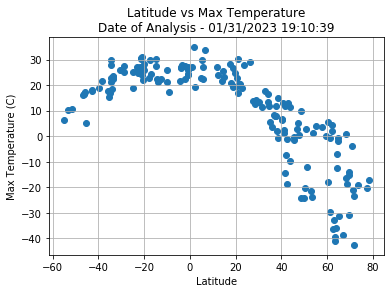

In [40]:
plot_latitude_vs_variable(plot_weather_data, "Max Temperature (C)", "Latitude vs Max Temperature")

## Latitude vs. Humidity Plot

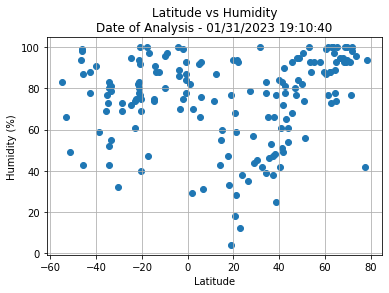

In [41]:
plot_latitude_vs_variable(plot_weather_data, "Humidity (%)", "Latitude vs Humidity")

## Latitude vs. Cloudiness Plot

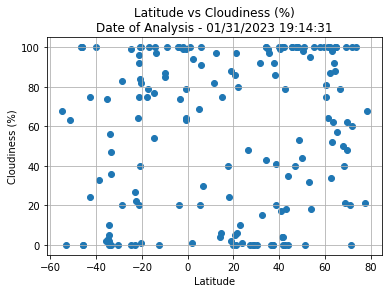

In [54]:
plot_latitude_vs_variable(plot_weather_data, "Cloudiness (%)", "Latitude vs Cloudiness (%)")

## Latitude vs. Wind Speed Plot

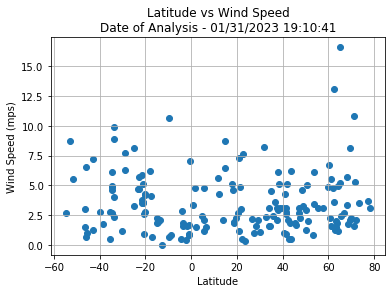

In [43]:
# latitude vs wind speed
plot_latitude_vs_variable(plot_weather_data, "Wind Speed (mps)", "Latitude vs Wind Speed")

## Linear Regression

In [44]:
# variables extract only the required hemisphere data from the weather_data dataframe
northern_hemisphere = weather_data[weather_data["Lat"] >= 0]
southern_hemisphere = weather_data[weather_data["Lat"] < 0]

In [45]:
from datetime import datetime

# create a function to plot latitude vs variable
def plot_regression(dataframe, x_variable, y_variable, title):
#   plot_regression(northern_hemisphere, "Lat", "Max Temp", "Max Temperature vs. Latitude")
    x_values = dataframe[x_variable]
    y_values = dataframe[y_variable]
    
    # calculate the regression line parameters (slope, intercept, etc.) using the linregress function
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    
    # calculate the regression line values based on the slope and intercept
    regress_values = x_values * slope + intercept

    # create a scatter plot figure and axis object
    fig, ax = plt.subplots(figsize=(5.5, 4.8))
    
    # plot the scatter plot of x_values and y_values
    ax.scatter(x_values, y_values)
    
    # plot the regression line on the scatter plot
    ax.plot(x_values, regress_values, "r-")
    
    # add grid to the plot
    ax.grid()

    # label the x-axis as "Latitude"
    plt.xlabel("Latitude")
    
    # label the y-axis with the input y_var column name
    plt.ylabel(y_variable)

    # get the current date and time and use it as part of the plot title
    date_time = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
    
    # set the title of the plot as input title with date and time of analysis
    plt.title(f"{title} Linear Regression\nDate of Analysis - {date_time}")
    
    # adjust the plot to fit in the figure
    plt.subplots_adjust(top=0.9)

    # add text to the plot showing the r-value and equation of the regression line
    plt.text(0.5, -0.3,
    f"The r-value is: {rvalue}\nThe line equation is: y = {round(slope, 2)}x + {round(intercept, 2)}",
    fontsize=12, ha="center", va="bottom", bbox=dict(facecolor="white", alpha=0.5),
    transform=ax.transAxes)

    # set tight layout for the plot
    plt.tight_layout()
    
    # save the plot to a file named as the input title with .png extension in the "plot_images" folder
    plt.savefig(f"plot_images/{title}.png", dpi=300, bbox_inches='tight')
    
    # display the plot
    plt.show()


###  Max Temp vs. Latitude Linear Regression

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

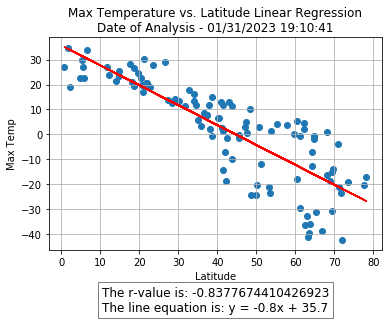

In [46]:
plot_regression(northern_hemisphere, "Lat", "Max Temp", "Max Temperature vs. Latitude")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

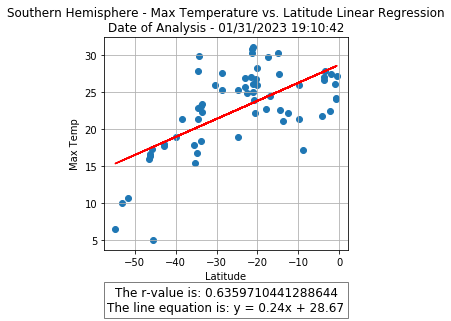

In [47]:
plot_regression(southern_hemisphere, "Lat", "Max Temp", "Southern Hemisphere - Max Temperature vs. Latitude")

### Humidity (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

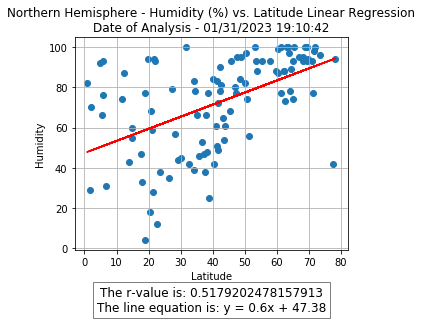

In [48]:
plot_regression(northern_hemisphere, "Lat", "Humidity", "Northern Hemisphere - Humidity (%) vs. Latitude")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

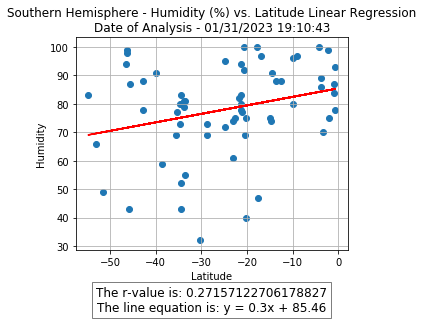

In [49]:
plot_regression(southern_hemisphere, "Lat", "Humidity", "Southern Hemisphere - Humidity (%) vs. Latitude")

### Cloudiness (%) vs. Latitude Linear Regression

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

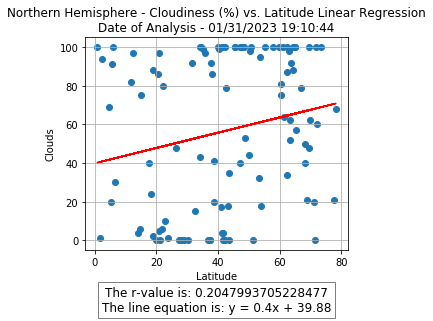

In [50]:
plot_regression(northern_hemisphere, "Lat", "Clouds", "Northern Hemisphere - Cloudiness (%) vs. Latitude")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

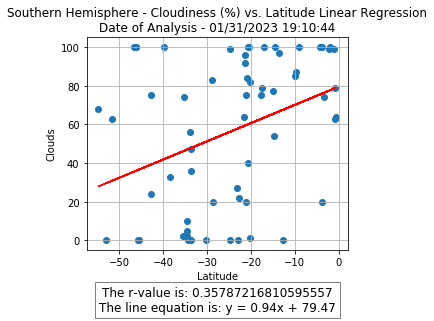

In [51]:
plot_regression(southern_hemisphere, "Lat", "Clouds", "Southern Hemisphere - Cloudiness (%) vs. Latitude")

### Wind Speed (m/s) vs. Latitude Linear Regression

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

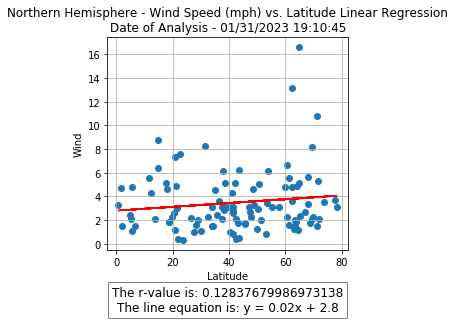

In [52]:
plot_regression(northern_hemisphere, "Lat", "Wind", "Northern Hemisphere - Wind Speed (mph) vs. Latitude")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

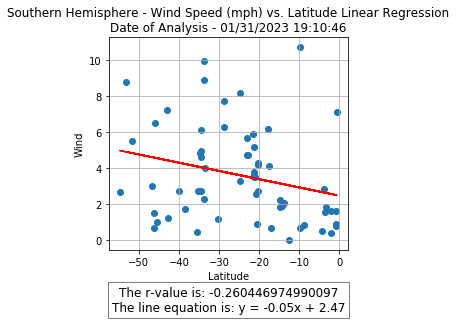

In [53]:
plot_regression(southern_hemisphere, "Lat", "Wind", "Southern Hemisphere - Wind Speed (mph) vs. Latitude")